In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(reshape2)
source('/home//workspace/IHA_Figure_Revision/helper_function/helper_function_IHA.r')

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘reshape2’ was built under R version 4.3.3”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
color_annotation<-read.csv('/home/workspace/IHA_Figure_Revision/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(" cell",'',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [3]:
meta_data=read.csv("Copy of Table S1 Cohort Details - Qiu.csv")

In [4]:
unique(meta_data$Group)

[1] "Control (HC1)"        "ACPA+ At-risk (ARI)"  "ACPA+ Early RA (ERA)"
[4] "Control (HC2)"        ""

In [5]:
files <- list.files("sample_normalized_count_average/", full.names = FALSE)
file_names <- tools::file_path_sans_ext(files)

In [6]:
meta_data<-meta_data %>% filter(Sample.ID %in% file_names,Group %in% c("Control (HC1)",
                                                                       'ACPA+ At-risk (ARI)'))

In [7]:
meta_data<-meta_data %>% filter(Age.at.sample.collection..yrs.>=20,Age.at.sample.collection..yrs.<=40)

In [8]:
meta_data$pbmc_sample_id<-meta_data$Sample.ID

In [9]:
file_list<-paste0("sample_normalized_count_average/", meta_data$pbmc_sample_id, ".csv")

In [10]:
df_list<-read_pseudobulk_expression(file_list,
                                    mc_cores = 15)

[1] "Total reading time: 5.625 seconds"
[1] "The length of the list matches the length of the input path."


In [11]:
deseq2_result_Y1D0<-read.csv('/home//workspace/IHA_Figure_Revision/Figure1/02_DEG/Deseq2_Result_Y1D0.csv')

In [12]:
 #filter significant genes 
deseq2_result_Y1D0_AgeGroup_sig<-deseq2_result_Y1D0 %>% 
  filter(contrast == "cohort.cohortGuid") %>%
  filter(padj < 0.05, 
         abs(log2FoldChange) > 0.1)

In [13]:
df_degs_counts<-as.data.frame(table(deseq2_result_Y1D0_AgeGroup_sig$celltype,
                                    deseq2_result_Y1D0_AgeGroup_sig$Direction))

In [14]:
df_degs_counts_filtered<-df_degs_counts %>% filter(Var2=="HigherInBR2") %>% 
arrange(Var1)   %>% filter(Freq>20)

In [15]:
score_df_list <- mclapply(unique(df_degs_counts_filtered$Var1), function(celltype_single) {
    top_n <- 100
    Direction_of_DEG <- "HigherInBR2"
    
    selected_genes <- deseq2_result_Y1D0_AgeGroup_sig %>%
        filter(celltype == celltype_single, Direction == Direction_of_DEG) %>%
        arrange(padj, desc(abs(log2FoldChange))) %>% 
        slice_head(n = top_n) %>%
        select(gene) %>%
        pull()
    selected_genes<-intersect(selected_genes,rownames(df_list[[1]]))
    print(length(selected_genes))
    long_format <- filter_genes_and_celltype(df_list, selected_genes, celltype_single, longformat = TRUE) %>%
        left_join(meta_data) %>%
        filter(!is.na(Mean_Expression)) %>%
        group_by(Gene) %>%
        mutate(Z_score_Mean_Expression = scale(Mean_Expression)) %>%
        ungroup()
    
    composite_score_df <- long_format %>%
        group_by(pbmc_sample_id) %>%
        summarise(
            composite_score_sum_mean = sum(Mean_Expression, na.rm = TRUE),
            composite_score_sum_scaled_mean = sum(Z_score_Mean_Expression, na.rm = TRUE)
        ) %>%
        left_join(meta_data) %>%
        mutate(celltype = celltype_single) %>%
        as.data.frame()
    
    return(composite_score_df)
}, mc.cores = 10)


In [27]:
composite_score_df_all<-do.call(rbind,score_df_list)

In [28]:
write.csv(composite_score_df_all,'RA_CompositeScore_Up.csv')

In [29]:
library(ggpubr)


Warning message in wilcox.test.default(c(21, 40, 39, 32, 33, 22, 36, 31, 36, 36, :
“cannot compute exact p-value with ties”


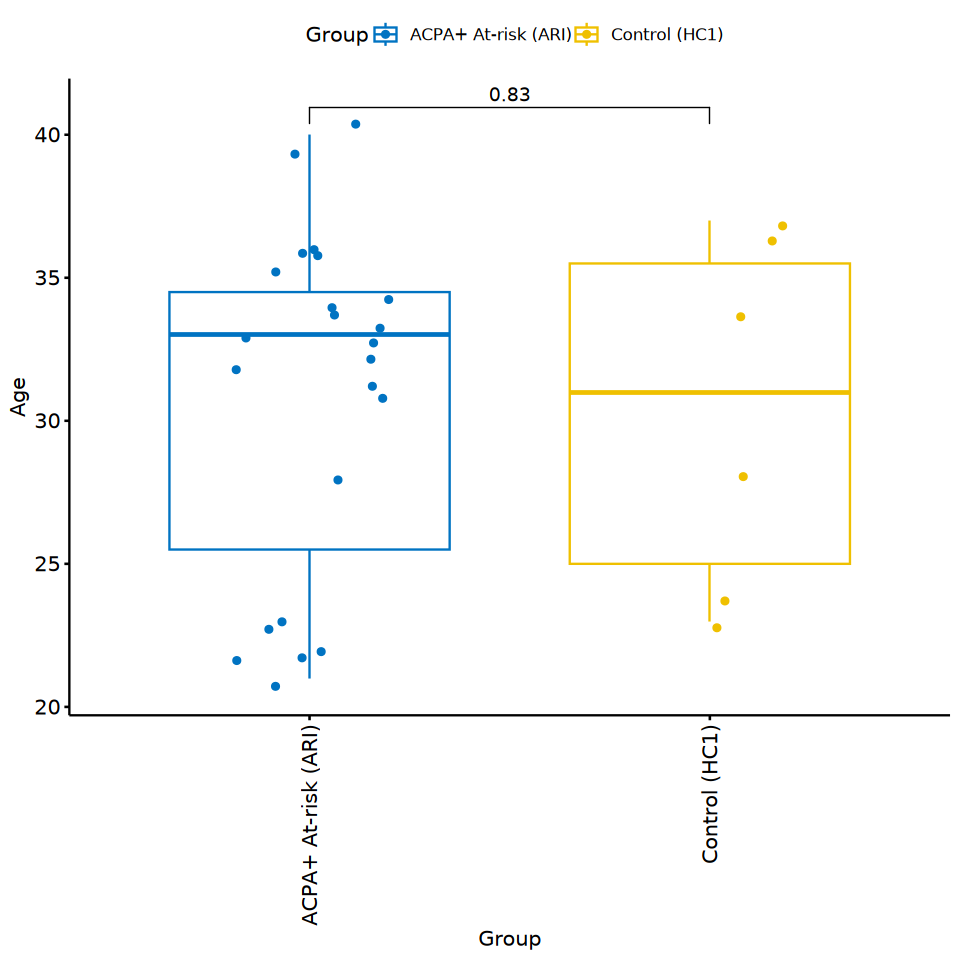

In [31]:
group_levels <- levels(factor(composite_score_df_all$Group))
my_comparisons <- combn(group_levels, 2, simplify = FALSE)
options(repr.plot.width = 8, repr.plot.height = 8)

p <- ggboxplot(composite_score_df_all %>% filter(celltype=="CM CD8 T cell"), x = "Group", y = "Age.at.sample.collection..yrs.",
               color = "Group", palette = "jco", add = "jitter") +
     stat_compare_means(method = "wilcox.test", comparisons = my_comparisons, 
                        group.by = "celltype") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+ylab("Age")

p

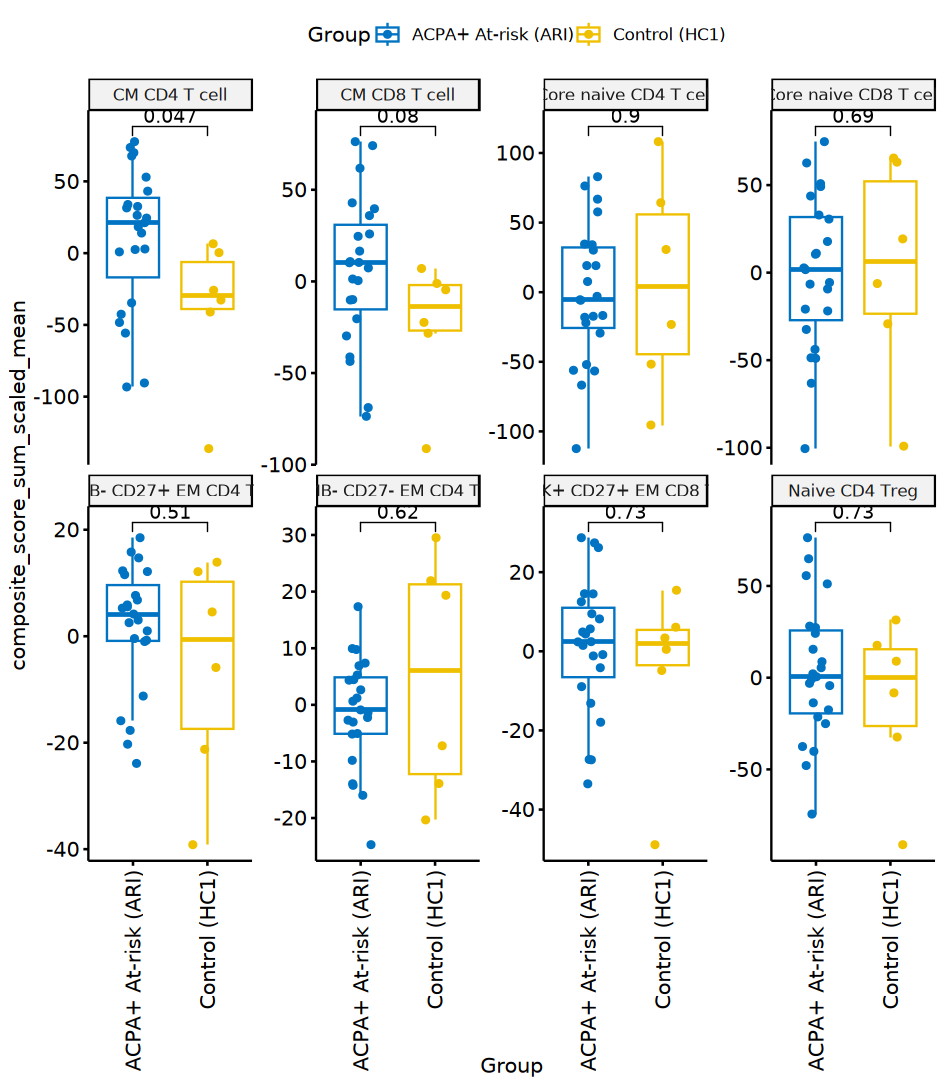

In [32]:

options(repr.plot.width = 200/25.4, repr.plot.height = 230/25.4)

group_levels <- levels(factor(composite_score_df_all$Group))
my_comparisons <- combn(group_levels, 2, simplify = FALSE)

p <- ggboxplot(composite_score_df_all,
               x = "Group", 
               y = "composite_score_sum_scaled_mean",
               color = "Group", palette = "jco", add = "jitter") +
     stat_compare_means(method = "wilcox.test", 
                        comparisons = my_comparisons, 
                        group.by = "celltype") +
     facet_wrap(~celltype,
                ncol=4,
                scale="free_y")+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

p